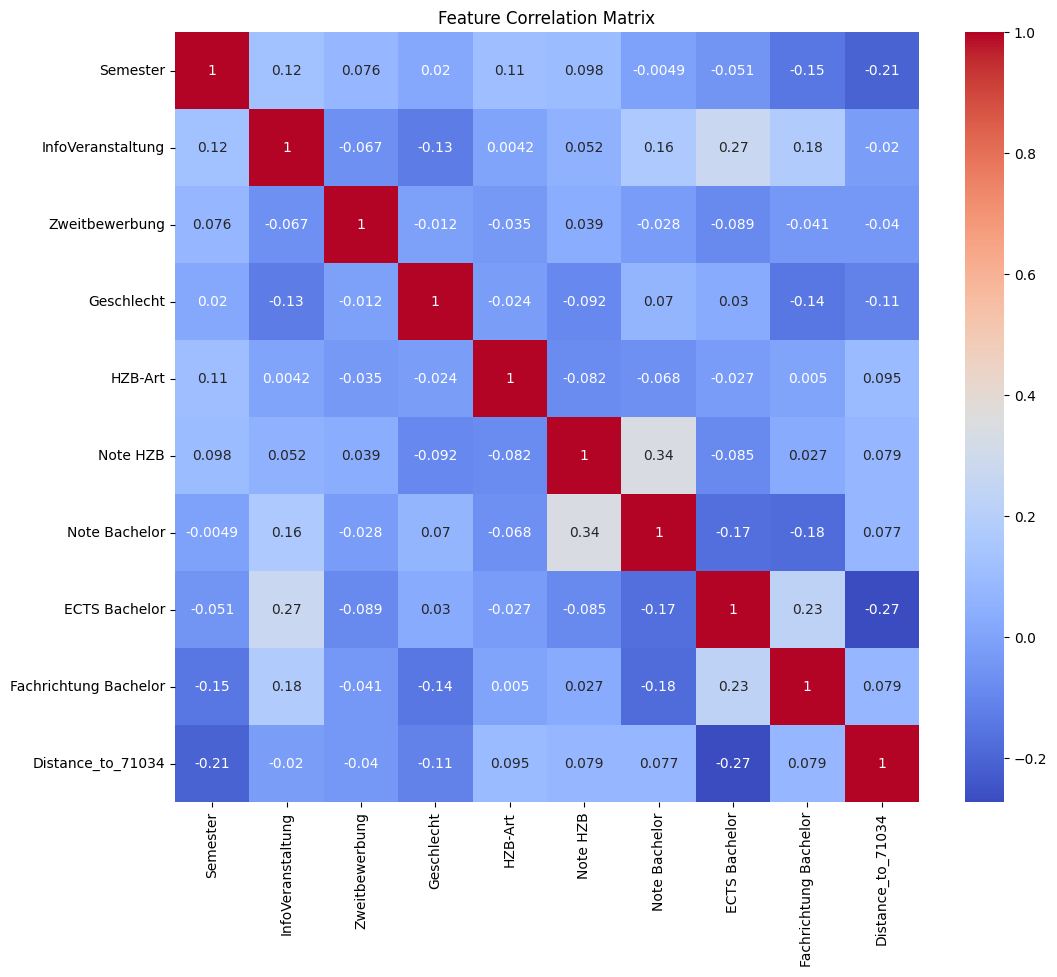

Random Forest Accuracy: 0.7241
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.78      0.54      0.64        13

    accuracy                           0.72        29
   macro avg       0.74      0.71      0.71        29
weighted avg       0.73      0.72      0.71        29

Random Forest Confusion Matrix:
[[14  2]
 [ 6  7]]


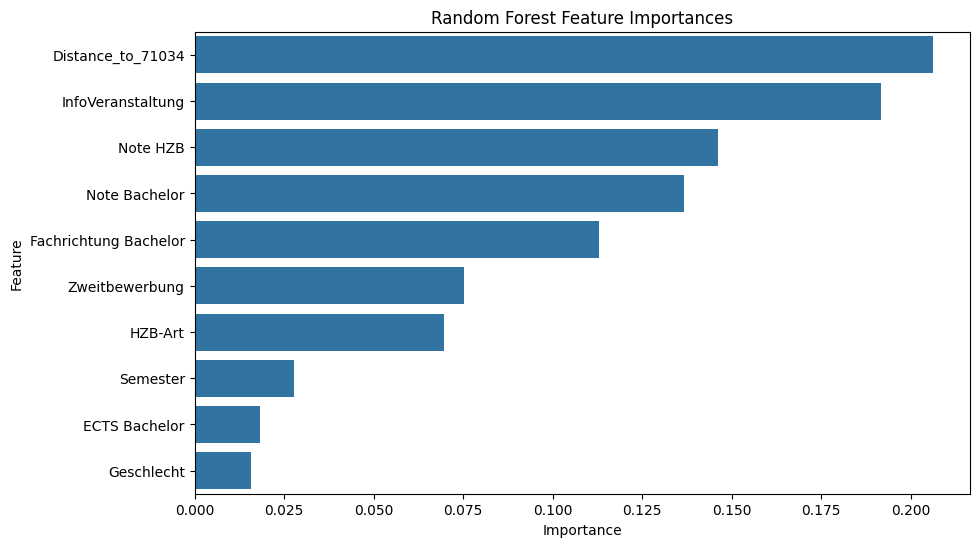

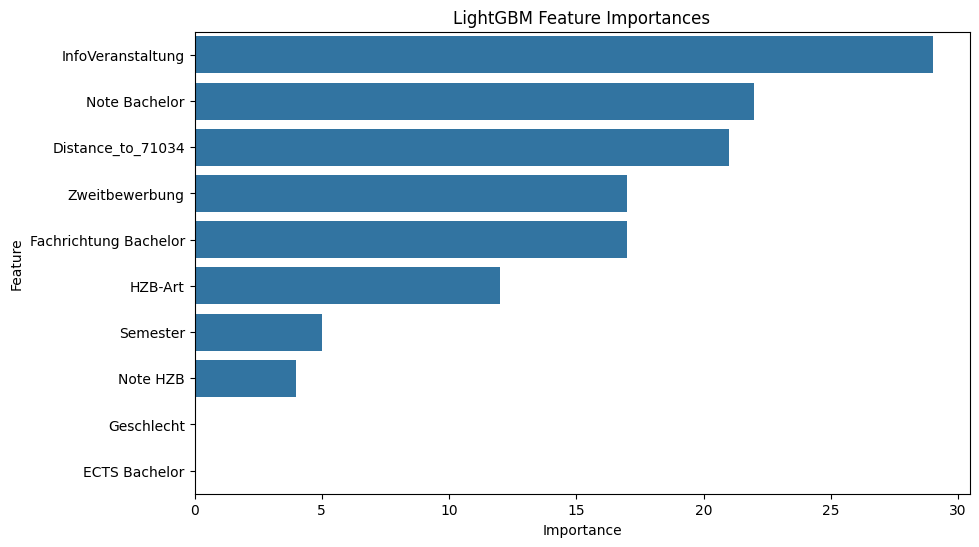

Logistic Regression Accuracy: 0.6897
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        16
           1       0.75      0.46      0.57        13

    accuracy                           0.69        29
   macro avg       0.71      0.67      0.66        29
weighted avg       0.70      0.69      0.67        29

Logistic Regression Confusion Matrix:
[[14  2]
 [ 7  6]]


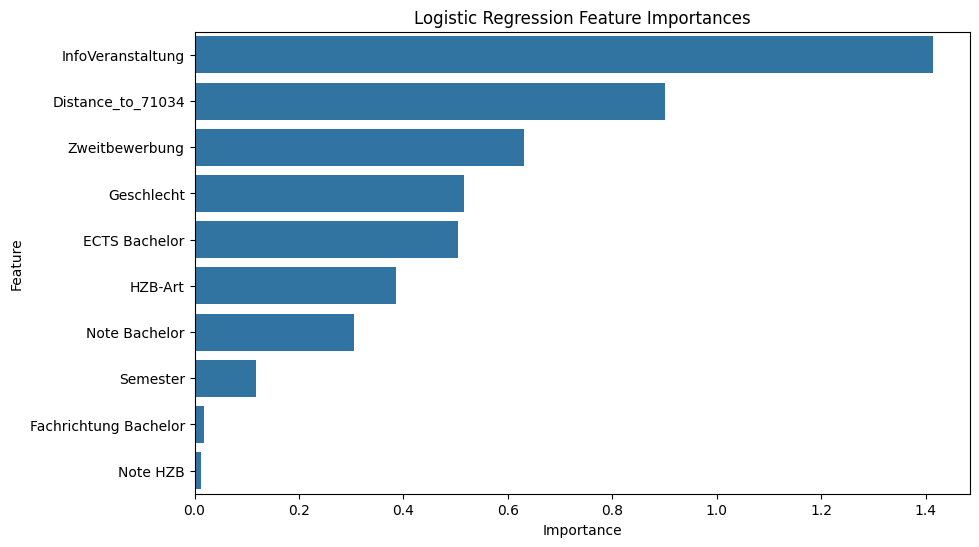

SVM Accuracy: 0.7241
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        16
           1       0.86      0.46      0.60        13

    accuracy                           0.72        29
   macro avg       0.77      0.70      0.69        29
weighted avg       0.76      0.72      0.70        29

SVM Confusion Matrix:
[[15  1]
 [ 7  6]]
Feature importance not available for SVM


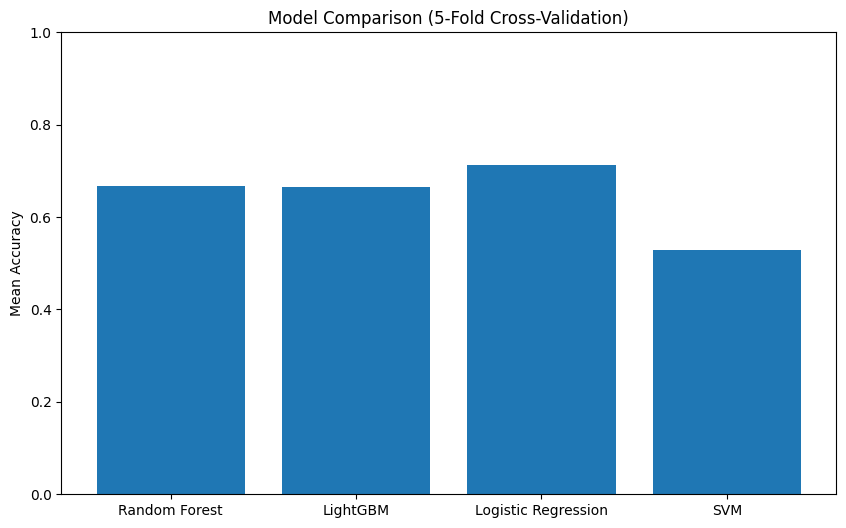

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb

# Load the dataset
data = pd.read_excel('data_with_distances.xlsx')

# Prepare the dataset
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

data = data.dropna()

# Define features (X) and target (y)
y = data['Immatrikulation']
X = data.drop(['Immatrikulation'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Correlation Analysis
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Function to evaluate and plot feature importance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_name} Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Feature importance not available for {model_name}")
        return
    
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'{model_name} Feature Importances')
    plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

# LightGBM
params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'binary_error', 'verbose': -1}
d_train = lgb.Dataset(X_train_scaled, label=y_train)
lgb_model = lgb.train(params, d_train, 100)
lgb_importances = lgb_model.feature_importance()

plt.figure(figsize=(10, 6))
lgb_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': lgb_importances})
lgb_feature_importance_df = lgb_feature_importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=lgb_feature_importance_df)
plt.title('LightGBM Feature Importances')
plt.show()

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")

# Support Vector Machine
svm = SVC(random_state=42)
evaluate_model(svm, X_train_scaled, y_train, X_test_scaled, y_test, "SVM")

# Compare all models using cross-validation
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42)
}

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_scores[name] = scores.mean()

plt.figure(figsize=(10, 6))
plt.bar(cv_scores.keys(), cv_scores.values())
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.show()